In [28]:
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import sys
import pytz
import math
from math import pow
from math import radians
import astropy.time
import astropy.coordinates
import lumos.calculator
import lumos.conversions
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import pytz
import math
from math import radians
import pandas as pd
from pyorbital.orbital import Orbital


sys.path.append('/Users/physarah/Development/satellite-optical-brightness/analysis')


import satellite_models.diffuse_sphere as diffuse_sphere
import satellite_models.starlink_v1p5 as starlink_v1p5
%matplotlib inline

satellite_data = pd.read_csv('/Users/physarah/Desktop/cleaned_data/tle_sat_data.csv')

In [4]:
satellite_data.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0',
       'source_mean', 'source_median', 'source_sum', 'source_rate', 'sky_mean',
       'sky_median', 'sky_sum', 'sky_rate', 'target_mean', 'target_median',
       'target_sum', 'target_rate', 'sc_area', 'bk_area', 'exposure_time',
       'datetimes_sat', 'gains_sat', 'airmass', 'm_inst', 'm_inst_sky',
       'calibed_mags', 'altitude', 'azimuth', 'utc', 'zenith_angle',
       'km_distance', 'sunsep', 'sat_name', 'norad_id', 'v_type',
       'tle_filename', 'tle1', 'tle2', 'tle3'],
      dtype='object')

In [33]:
ts = load.timescale()

altitudes_line = []
azimuths_line = []
distance_list_line = []
times = []
altitudes = []
longitude = []
latitude = []

for index, row_data in satellite_data.iterrows():

    orb_sat = Orbital(satellite=row_data['tle1'], line1=row_data['tle2'], line2=row_data['tle3'])

    satellite = EarthSatellite(row_data['tle2'], row_data['tle3'], name=row_data['tle1'])        
    observer_location = Topos('33.7703 S', '151.1112 E', elevation_m=70) # Macquarie Observatory
    TIME_PD = pd.to_datetime(row_data['datetimes_sat']).replace(tzinfo=pytz.utc)
    time_sf = ts.utc(TIME_PD)

    topocentric = (satellite - observer_location).at(time_sf)
    satellite_position = satellite.at(time_sf)
    earth_radius_km = 6371.0  

    observer_latitude = radians(-33.7703)  
    observer_longitude = radians(151.1112)  
    
    delta_longitude = satellite_position.subpoint().longitude.radians - observer_longitude
    delta_latitude = satellite_position.subpoint().latitude.radians - observer_latitude

    a = (pow(math.sin(delta_latitude / 2), 2) +
         math.cos(observer_latitude) * math.cos(satellite_position.subpoint().latitude.radians) *
         pow(math.sin(delta_longitude / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance_km = earth_radius_km * c
    distance_list_line.append(distance_km)

    lon, lat, height = orb_sat.get_lonlatalt(pd.to_datetime(row_data['datetimes_sat']))
    longitude.append(lon)
    latitude.append(lat)
    altitudes.append(height)
    alt, az, _ = topocentric.altaz()
    altitudes_line.append(alt.degrees)
    azimuths_line.append(az.degrees)
    times.append(time_sf.utc_datetime())

In [65]:
satellite_data['altitude2'] = altitudes_line
satellite_data['azimuth2'] = azimuths_line
satellite_data['forest_time'] = times
satellite_data['line_distance'] = distance_list_line
satellite_data['sat_height'] = np.array(altitudes)*1000
satellite_data['longitude'] = longitude
satellite_data['latitude'] = latitude

In [66]:
mount_lemmon = astropy.coordinates.EarthLocation(lat = -33.7703, lon = 151.1112)

In [67]:
import lumos.constants as cst
cst.SUN_INTENSITY

1233

In [68]:
lumos.constants.WAVELENGTH

5.32e-07

In [105]:
intensities_lab_brdfs = []

sun_alt_list, sun_az_list = ([],[])
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_data['altitude2'], satellite_data['azimuth2'], satellite_data['sat_height'], satellite_data['datetimes_sat'])):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_lab_brdfs.append( \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=300,
            #earth_brdf=lumos.brdf.library.PHONG(0.48, 0.008, 16.45))) # use the vegitation example that Forrest uses 
            earth_brdf=lumos.brdf.library.LAMBERTIAN(0.9)))
    # intensities_inferred_brdfs[i] = \
    #     lumos.calculator.get_intensity_observer_frame(
    #         starlink_v1p5.SURFACES_INFER_BRDFS,
    #         sat_h, sat_alt, sat_az, sun_alt, sun_az,
    #         include_earthshine = True,
    #         earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31)) # use the vegitation example that Forrest uses 

#magnitudes_diffuse_sphere = lumos.conversions.intensity_to_ab_mag(intensities_diffuse_sphere)
#magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs)
#magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)

In [106]:
float_list = np.array([float(arr) for arr in intensities_lab_brdfs])
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(float_list)

In [107]:
magnitudes_lab_brdfs

array([2.53021568, 3.44865923, 3.51430026, 3.31322421, 3.38030611,
       3.333359  , 3.08047069, 3.5201494 , 3.56223878, 3.10807568,
       3.09355543, 3.4808394 , 3.45250093, 3.53303286, 3.58047887,
       3.19257648, 2.89891273, 3.58305945, 3.59243283, 3.50433132,
       3.53712955, 3.12525579, 3.42482498, 3.66866244, 3.54540523,
       3.36287813, 3.57310284, 3.49729189, 3.60699232, 3.70738635,
       3.49623663, 3.17120232, 3.62776793, 3.68829047, 3.72575165,
       3.70727667, 3.42892247, 3.78000837, 3.73697402, 3.55490008,
       3.57661288, 3.58233191, 3.57557151, 3.59353212, 3.59972063,
       3.52029978, 3.57903662, 3.74300944, 3.74322307, 3.6110734 ,
       3.87339982, 3.89543244, 2.9756636 , 3.89090053, 3.86907664,
       3.80863491, 3.81615864, 2.65480198, 3.76722145, 3.62374408,
       3.9322653 , 3.8672728 , 3.49156415, 3.76904184, 2.96476584,
       3.84050461, 3.89385246, 3.89780992, 3.83117407, 3.01685198,
       3.77594302, 3.56701249, 3.95198583, 3.96522567, 3.74970

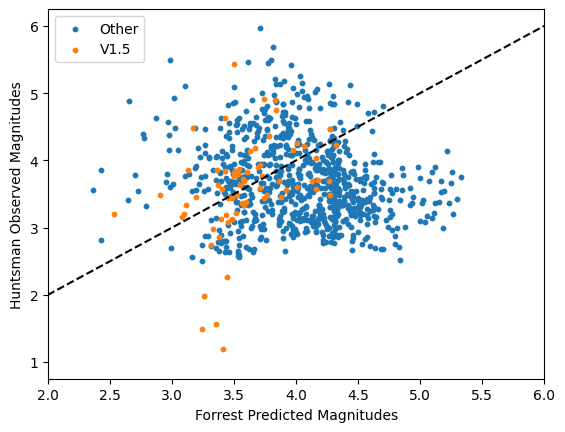

In [108]:
satellite_data['forrest_magnitudes'] = magnitudes_lab_brdfs

satellite_data_v1 = satellite_data[satellite_data['v_type']=='V1']
satellite_data_v15 = satellite_data[satellite_data['v_type']=='V1.5']

plt.scatter(x = satellite_data_v1['forrest_magnitudes'], y = satellite_data_v1['calibed_mags'], s = 10, label = 'Other')
plt.scatter(x = satellite_data_v15['forrest_magnitudes'], y = satellite_data_v15['calibed_mags'], s = 10, label = 'V1.5')
plt.legend()
plt.plot(np.linspace(1,6,100),np.linspace(1,6,100), c = 'black', ls = '--')
plt.xlim(2,6)
plt.xlabel("Forrest Predicted Magnitudes")
plt.ylabel("Huntsman Observed Magnitudes")
plt.savefig('/Users/physarah/Desktop/model_comparison3.png')

In [84]:
intensities_lab_brdfs_greenery = []

sun_alt_list, sun_az_list = ([],[])
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_data['altitude2'], satellite_data['azimuth2'], satellite_data['sat_height'], satellite_data['datetimes_sat'])):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_lab_brdfs_greenery.append( \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=300,
            earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31))) # use the vegitation example that Forrest uses 
            #earth_brdf=lumos.brdf.library.LAMBERTIAN(0.8))
    # intensities_inferred_brdfs[i] = \
    #     lumos.calculator.get_intensity_observer_frame(
    #         starlink_v1p5.SURFACES_INFER_BRDFS,
    #         sat_h, sat_alt, sat_az, sun_alt, sun_az,
    #         include_earthshine = True,
    #         earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31)) # use the vegitation example that Forrest uses 

#magnitudes_diffuse_sphere = lumos.conversions.intensity_to_ab_mag(intensities_diffuse_sphere)
#magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs)
#magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)

In [86]:
float_list = np.array([float(arr) for arr in intensities_lab_brdfs_greenery])
magnitudes_lab_brdfs_greenery = lumos.conversions.intensity_to_ab_mag(float_list)

In [88]:
satellite_data['forrest_magnitudes_green'] = magnitudes_lab_brdfs_greenery


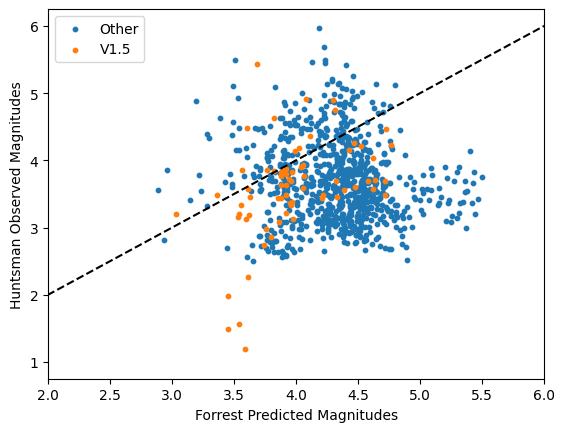

In [89]:

satellite_data_v1 = satellite_data[satellite_data['v_type']=='V1']
satellite_data_v15 = satellite_data[satellite_data['v_type']=='V1.5']

plt.scatter(x = satellite_data_v1['forrest_magnitudes_green'], y = satellite_data_v1['calibed_mags'], s = 10, label = 'Other')
plt.scatter(x = satellite_data_v15['forrest_magnitudes_green'], y = satellite_data_v15['calibed_mags'], s = 10, label = 'V1.5')
plt.legend()
plt.plot(np.linspace(1,6,100),np.linspace(1,6,100), c = 'black', ls = '--')
plt.xlim(2,6)
plt.xlabel("Forrest Predicted Magnitudes")
plt.ylabel("Huntsman Observed Magnitudes")
plt.savefig('/Users/physarah/Desktop/model_comparison2.png')

In [90]:
satellite_data

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,source_mean,source_median,source_sum,source_rate,sky_mean,sky_median,...,tle3,altitude2,azimuth2,forest_time,line_distance,sat_height,longitude,latitude,forrest_magnitudes,forrest_magnitudes_green
0,0,0,0,0,40088.034492,39851.885018,1.523391e+07,4.176246e+06,39646.573047,39607.401736,...,2 52534 53.2164 36.1108 0001558 94.3609 265...,67.924527,66.582436,2024-01-18 06:31:22.517000+00:00,204.055336,550866.120023,153.118479,-33.021993,3.139481,3.034057
1,1,1,1,1,40026.502876,39773.284445,1.521126e+07,4.170034e+06,39547.232800,39538.464431,...,2 52534 53.2164 36.1108 0001558 94.3609 265...,67.474004,66.068600,2024-01-18 06:31:23.251000+00:00,208.619186,550852.592118,153.154505,-32.989585,3.965312,3.863055
2,2,2,2,2,39998.665762,39776.578057,1.520308e+07,4.167794e+06,39573.237105,39603.447053,...,2 52534 53.2164 36.1108 0001558 94.3609 265...,66.940026,65.486548,2024-01-18 06:31:24.123000+00:00,214.061905,550836.518301,153.197267,-32.951068,4.018646,3.917509
3,3,3,3,3,40259.760369,39916.365567,1.529971e+07,4.194283e+06,39613.266684,39615.050808,...,2 52534 53.2164 36.1108 0001558 94.3609 265...,66.491776,65.018991,2024-01-18 06:31:24.857000+00:00,218.659630,550822.986187,153.233231,-32.918633,3.843786,3.742284
4,4,4,4,4,41738.692847,41447.909022,1.586290e+07,4.172991e+06,41133.477728,41122.924689,...,2 52534 53.2164 36.1108 0001558 94.3609 265...,66.041143,64.567028,2024-01-18 06:31:25.597000+00:00,223.309079,550809.341552,153.269461,-32.885920,3.899882,3.799324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,893,893,75,75,56672.211484,56679.154791,2.154119e+07,7.933300e+06,56524.240433,56501.143108,...,2 57942 53.0564 47.0643 0002577 120.7942 239...,28.345930,46.037462,2024-01-18 07:18:49.909000+00:00,800.352689,519912.821254,156.995378,-28.620875,5.478445,5.426801
894,894,894,76,76,56983.010013,56924.003722,2.166115e+07,7.977479e+06,56856.610574,56817.235166,...,2 57942 53.0564 47.0643 0002577 120.7942 239...,28.160504,46.022448,2024-01-18 07:18:50.657000+00:00,805.407083,519899.075018,157.029000,-28.586257,5.488548,5.437172
895,895,895,77,77,57445.745330,57406.944528,2.183662e+07,8.042100e+06,57217.227462,57217.159424,...,2 57942 53.0564 47.0643 0002577 120.7942 239...,27.950585,46.005511,2024-01-18 07:18:51.511000+00:00,811.177852,519883.381999,157.067358,-28.546721,5.492630,5.441159
896,896,896,79,79,58253.116150,58239.354019,2.214154e+07,8.154399e+06,58063.019277,58047.983076,...,2 57942 53.0564 47.0643 0002577 120.7942 239...,27.560883,45.974234,2024-01-18 07:18:53.117000+00:00,822.030457,519853.873944,157.139407,-28.472334,5.518822,5.468151


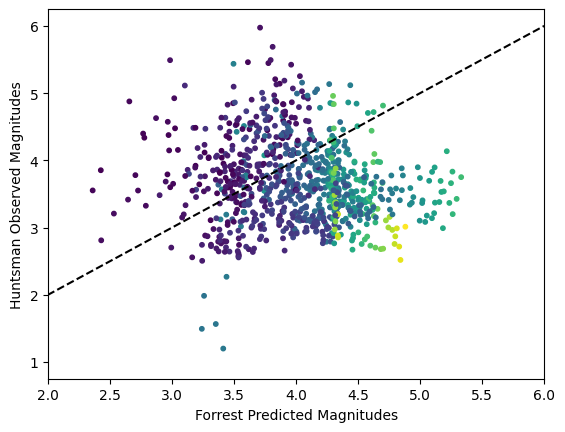

In [115]:
plt.scatter(x = satellite_data['forrest_magnitudes'], y = satellite_data['calibed_mags'], s = 10, c = satellite_data['airmass'])
plt.plot(np.linspace(1,6,100),np.linspace(1,6,100), c = 'black', ls = '--')
plt.xlim(2,6)
plt.xlabel("Forrest Predicted Magnitudes")
plt.ylabel("Huntsman Observed Magnitudes")
plt.savefig('/Users/physarah/Desktop/model_comparison3.png')

In [116]:
satellite_data.rename(columns={'forrest_magnitudes': 'forrest_magnitudes_lambertian_09'}, inplace=True)


In [118]:
df = satellite_data.drop(satellite_data.columns[:4], axis=1)


In [120]:
df.to_csv('/Users/physarah/Desktop/forrest_comparison_sat_data.csv')